# Goal

Can I create the 7th energy level of a Quantum Harmonic Oscillator, defined by $H = \frac{P^2}{2m} + \frac{1}{2}m \omega^2 X^2$, by fine tuning the $\omega$ parameter to follow a $\omega_t$ evolution?

# Imports

In [22]:
from copy import deepcopy
from dataclasses import dataclass
from functools import lru_cache
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.sparse.linalg import expm
from typing import Optional
import numpy as np
import scipy
import seaborn as sns

plt.figure(figsize=(20,3))

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

In [23]:
@dataclass
class Settings:
    n_time_intervals:int = 5
    number_of_energy_levels:int = 10
    omega:float = 10
    resolution:int = 500
    target_energy_level:int = 2
    time_delta:float = 10 / 5 # TODO: Automatise this total_evolution_time / n_time_intervals division
    total_evolution_time:float = 10
    x_max:float = 2
    x_min:float = -2

assert Settings.time_delta * Settings.n_time_intervals == Settings.total_evolution_time

    # @property
    # def time_delta(self):
    #     return self.total_evolution_time / self.n_time_intervals


# Setup Hamiltonian

In [24]:
valid_x = np.linspace(Settings.x_min, Settings.x_max, Settings.resolution)
delta_x = valid_x[1] - valid_x[0]
potential = lambda x: x**2

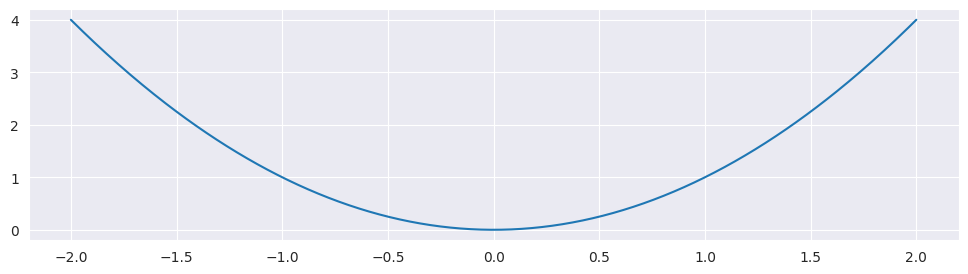

In [25]:
plt.figure(figsize=(12,3))
plt.plot(valid_x, [potential(x) for x in valid_x])

In [26]:
# Based on https://medium.com/@natsunoyuki/quantum-mechanics-with-python-de2a7f8edd1f
@lru_cache(maxsize=2*Settings.n_time_intervals)
def generate_hamiltonian(omega: float, center:float = 0):
    # P^2 term
    temp_hamiltonian = scipy.sparse.eye(Settings.resolution, Settings.resolution, format='lil') * 2
    for i in range(Settings.resolution - 1):
        temp_hamiltonian[i, i + 1] = -1
        temp_hamiltonian[i + 1, i] = -1

    # # Turns the space cyclic. Useful for modelling ring interferometry
    # inner_hamiltonian[0, resolution - 1] = -1
    # inner_hamiltonian[resolution - 1, 0] = -1

    temp_hamiltonian = np.divide(temp_hamiltonian, delta_x ** 2)

    # V(X) term
    for i in range(Settings.resolution):
        temp_hamiltonian[i, i] = temp_hamiltonian[i, i] + omega**2 * (valid_x[i] - center)**2

    return temp_hamiltonian.tocsc()

hamiltonian = generate_hamiltonian(omega=Settings.omega)

# Energy levels

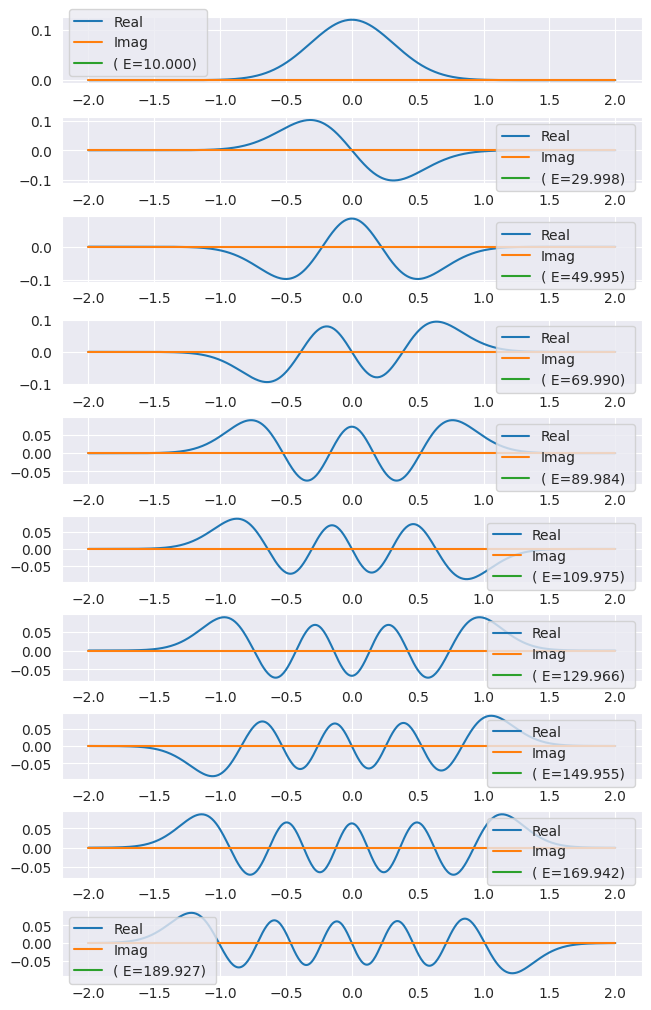

In [27]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(hamiltonian, k=Settings.number_of_energy_levels, which="SM")
fig, axes = plt.subplots(Settings.number_of_energy_levels, 1, layout='constrained')
fig.set_figheight(Settings.number_of_energy_levels)
for i, (val, vector) in enumerate(zip(eigenvalues, eigenvectors.T)):
    axes[i].plot(valid_x, np.real(vector), label=f"Real")
    axes[i].plot(valid_x, np.imag(vector), label=f"Imag")
    axes[i].plot([],[], label=f"( E={np.real(val):.3f}) ")
    axes[i].legend(loc='best')

plt.show()

# Orthonormality check

<Axes: >

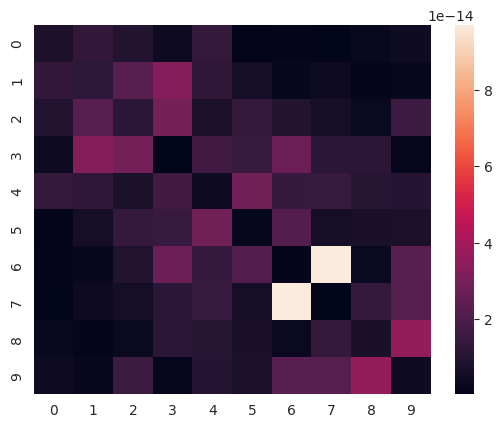

In [28]:
# Ideally this should all be zeroes
error_matrix = np.abs(eigenvectors.T @ eigenvectors) - np.eye(Settings.number_of_energy_levels)
sns.heatmap(np.abs(error_matrix))

# Origin state

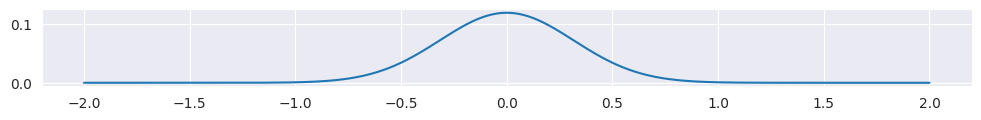

In [29]:
origin_state = eigenvectors[:, 0]
plt.figure(figsize=(12,1))
plt.plot(valid_x, np.real(origin_state))

# Target state

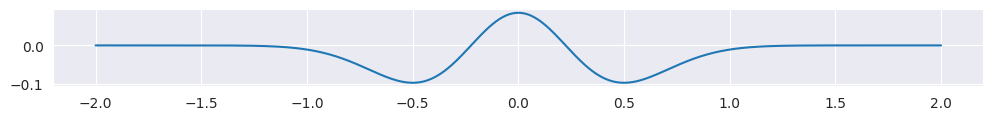

In [30]:
target_state = eigenvectors[:, Settings.target_energy_level]
plt.figure(figsize=(12,1))
plt.plot(valid_x, np.real(target_state))

# Auxiliary functions

We will split the time evolution into time_intervals. We want to find a vector of time choices that maximizes the final fidelity between the target state, and the evolved state

## Fidelity
$\mathcal{F} \coloneqq |\braket{\rho_a | \rho_b} |^2$

In [31]:
def fidelity(state_a: np.ndarray, state_b: np.ndarray) -> float:
    return np.sum(
        np.abs(
            np.divide(
                np.dot(state_a, state_b),
                np.linalg.norm(state_a) * np.linalg.norm(state_b) # Normalize
            )
        ) ** 2
    )

## State evolution
$\ket{\phi_{t+s}} = e^{isH_s} \ket{\phi_t}$

In [32]:
def evolve_state(omega_list: np.array, time_list:np.array, center_list:Optional[np.array] = None) -> np.array:
    assert len(omega_list) == len(time_list), f"The length of omega_list does not match the length of time_list: {len(omega_list)}!={len(time_list)}"

    if not center_list:
        center_list = np.zeros(len(omega_list))

    assert len(center_list) == len(time_list), f"The length of center_list does not match the length of time_list: {len(center_list)}!={len(time_list)}"

    evolved_state = deepcopy(origin_state)
    for temp_omega, temp_time, temp_center in zip(omega_list, time_list, center_list):
        evolved_state = expm(-1j * generate_hamiltonian(omega=temp_omega, center=temp_center) * temp_time) @ evolved_state
    return evolved_state

## Loss function

In [33]:
def loss(all_inputs: np.array) -> float:
    internal_omega_list, internal_time_list = np.resize(all_inputs, (2,int(len(all_inputs)/2)))
    internal_evolved_state = evolve_state(internal_omega_list, internal_time_list)
    loss_value = np.sum([
        10**3 * (1 - fidelity(internal_evolved_state, target_state))**2, # Fidelity
        10**-4 * np.divide(np.sum(internal_time_list) - Settings.total_evolution_time, Settings.total_evolution_time)**2, # Total time roughly as desired
        -1 * 10**3 * np.min([np.min(internal_time_list), 0]), # Force time to be positive
        -1 * 10**3 * np.min([np.min(internal_omega_list), 0]), # Force omega to be positive
        10**-4 * np.max(internal_omega_list)**2, # Prefer smaller omegas
        (np.linalg.norm(internal_evolved_state) - 1)**2 # Favor normalized end states
    ])

    # Useful for seeing progress during the optimization process
    if .1 > np.random.uniform(): # Avoid over printing
        print(f' < {100*fidelity(internal_evolved_state, target_state):.1f}% | {loss_value:.1f} | {", ".join(["{:.1f}".format(x) for x in all_inputs])} > ')

    return loss_value

## Plotting

In [34]:
def plot_waves(omega_list: np.array, time_list: np.array, show_fidelity:bool = True) -> None:
    assert len(omega_list) == len(time_list), f"The length of omega_list does not match the length of time_list: {len(omega_list)}!={len(time_list)}"
    n_time_intervals = len(omega_list)
    evolved_state = deepcopy(origin_state)
    fig, axes = plt.subplots(n_time_intervals + 1, 1, layout='constrained')
    fig.set_figheight(n_time_intervals * 2)
    axes[0].plot(valid_x, np.real(evolved_state), label="Real")
    axes[0].plot(valid_x, np.imag(evolved_state), label="Imag")
    if show_fidelity:
        axes[0].plot([], [], label=f"$\\mathcal{{F}}={fidelity(evolved_state, target_state):.2f}$")
    axes[0].legend(loc="best")

    for i, (temp_omega, temp_time) in enumerate(zip(omega_list, time_list)):
        evolved_state = expm(-1j * generate_hamiltonian(omega=temp_omega) * temp_time) @ evolved_state
        axes[i+1].plot(valid_x, np.real(evolved_state), label="Real")
        axes[i+1].plot(valid_x, np.imag(evolved_state), label="Imag")
        axes[i+1].plot(valid_x, np.real(target_state), label="target")
        if show_fidelity:
            axes[i+1].plot([], [], label=f"$\\mathcal{{F}}={100*fidelity(evolved_state, target_state):.2f}\\%$")
            axes[i+1].plot([] , [], label=f"$\\omega={temp_omega:.2f}$")
            axes[i+1].plot([] , [], label=f"$t={temp_time:.2f}$")
        axes[i+1].legend(loc="best")

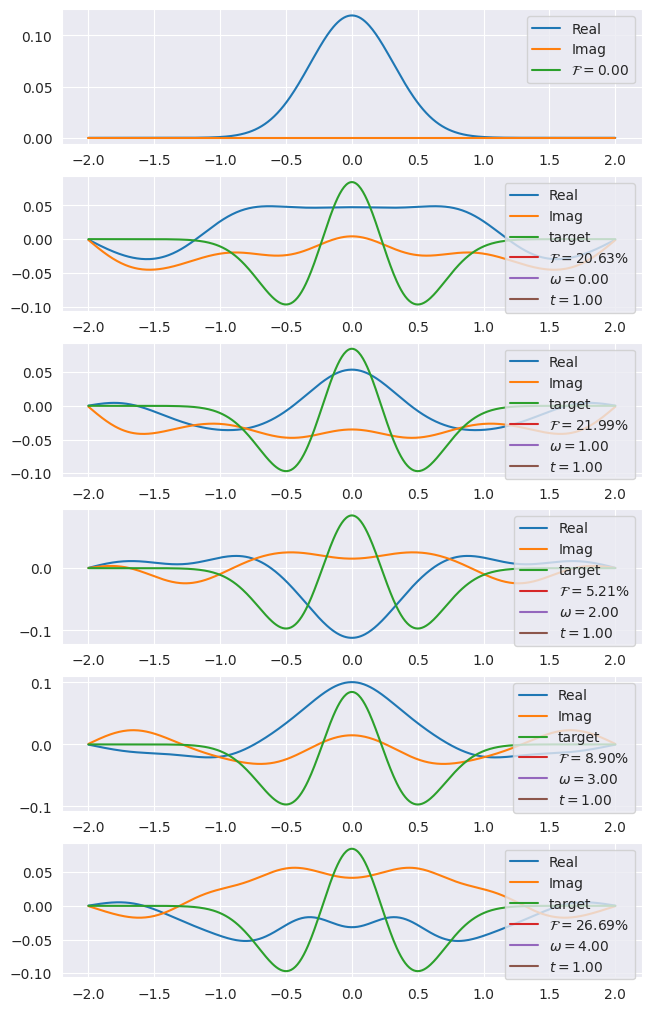

In [35]:
plot_waves(
    omega_list=range(Settings.n_time_intervals),
    time_list=np.ones(Settings.n_time_intervals)
)

# Optimization loop

In [15]:
initial_guess = np.concatenate((
    np.random.uniform(
        low=0,
        high=1.5 * Settings.omega,
        size=Settings.n_time_intervals
    ), # Initial omega
    np.random.uniform(
        low=Settings.time_delta,
        high=2*Settings.time_delta,
        size=Settings.n_time_intervals
    ) # Initial time interval
))
initial_guess

array([12.05703092,  3.26506226,  9.08605925, 13.2460402 ,  6.4442632 ,
        2.26525621,  3.31628419,  3.4730772 ,  2.03441426,  2.64480903])

In [16]:
# TODO: GPU based solution
# https://www.tensorflow.org/probability/api_docs/python/tfp/optimizer/bfgs_minimize
results = minimize(
    loss,
    x0 = initial_guess,
    method="BFGS",
    # method="Nelder-Mead",
    # method="Powell",
)
results

 < 0.9% | 982.4 | 12.1, 3.3, 9.1, 13.2, 6.4, 2.3, 3.3, 3.5, 2.0, 2.6 > 
 < 24.4% | 571.4 | 12.1, 3.3, 9.3, 13.4, 6.4, 2.4, 3.3, 4.0, 2.8, 2.7 > 
 < 17.4% | 681.9 | 12.1, 3.2, 9.4, 13.4, 6.4, 2.4, 3.2, 4.2, 2.9, 2.6 > 
 < 21.9% | 610.6 | 12.1, 3.2, 9.3, 13.4, 6.4, 2.4, 3.2, 4.1, 2.9, 2.6 > 
 < 21.9% | 610.6 | 12.1, 3.2, 9.3, 13.4, 6.4, 2.4, 3.2, 4.1, 2.9, 2.6 > 
 < 25.7% | 551.4 | 12.1, 3.3, 9.3, 13.4, 6.4, 2.4, 3.3, 4.1, 2.8, 2.7 > 
 < 25.7% | 551.4 | 12.1, 3.3, 9.3, 13.4, 6.4, 2.4, 3.3, 4.1, 2.8, 2.7 > 
 < 25.7% | 551.4 | 12.1, 3.3, 9.3, 13.4, 6.4, 2.4, 3.3, 4.1, 2.8, 2.7 > 
 < 19.4% | 648.9 | 12.1, 3.3, 9.3, 13.3, 6.5, 2.5, 3.2, 4.0, 2.8, 2.7 > 
 < 26.1% | 546.8 | 12.1, 3.3, 9.3, 13.4, 6.4, 2.4, 3.3, 4.1, 2.8, 2.7 > 
 < 26.1% | 546.8 | 12.1, 3.3, 9.3, 13.4, 6.4, 2.4, 3.3, 4.1, 2.8, 2.7 > 
 < 26.3% | 543.0 | 12.1, 3.3, 9.3, 13.3, 6.4, 2.4, 3.3, 4.0, 2.8, 2.7 > 
 < 26.8% | 536.2 | 12.1, 3.3, 9.3, 13.3, 6.5, 2.4, 3.3, 4.1, 2.8, 2.7 > 
 < 30.5% | 483.2 | 12.1, 3.3, 9.3, 13.3, 6.5, 2.5, 3

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 47.64360523071004
        x: [ 1.757e+01  3.400e+00  9.263e+00  1.438e+01  5.531e+00
             1.690e+00  3.113e+00  4.078e+00  2.639e+00  3.213e+00]
      nit: 84
      jac: [-2.575e-05  8.774e-05  6.208e-04 -1.079e-03  3.123e-04
            -8.869e-05 -3.743e-04  1.043e-03 -5.240e-04  4.282e-04]
 hess_inv: [[ 6.667e-04 -2.052e-05 ...  5.713e-06  5.760e-06]
            [-2.052e-05  8.131e-06 ...  3.273e-07  3.863e-06]
            ...
            [ 5.713e-06  3.273e-07 ...  9.529e-07 -2.341e-07]
            [ 5.760e-06  3.863e-06 ... -2.341e-07  4.052e-06]]
     nfev: 1596
     njev: 144

# Plots

In [17]:
omega_list, time_list = np.resize(results.x, (2,int(len(results.x)/2)))

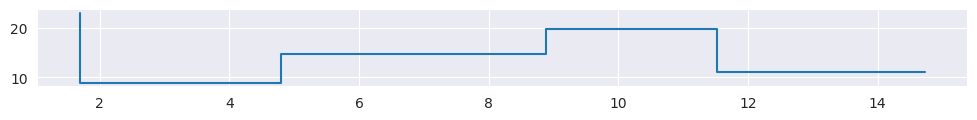

In [18]:
plt.figure(figsize=(12,1))
plt.step(x=[0] + np.cumsum(time_list), y=omega_list + [omega_list[-1]])

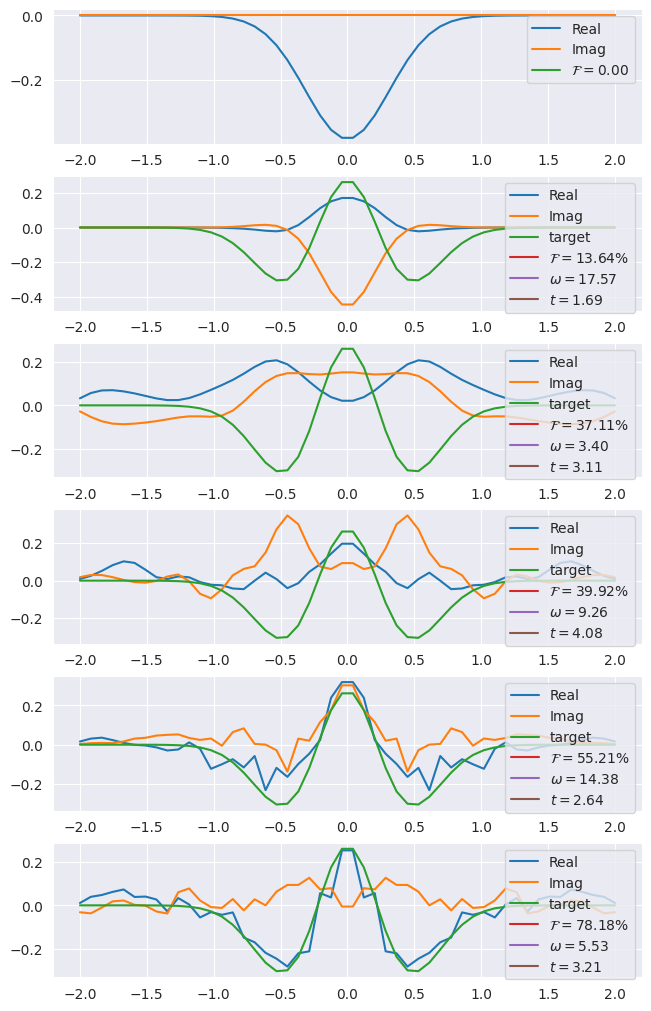

In [19]:
plot_waves(omega_list, time_list)

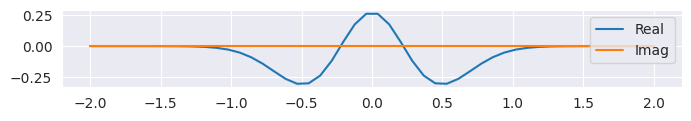

In [20]:
plt.figure(figsize=(8,1))
plt.plot(valid_x, np.real(target_state), label="Real")
plt.plot(valid_x, np.imag(target_state), label="Imag")
plt.legend(loc="best")

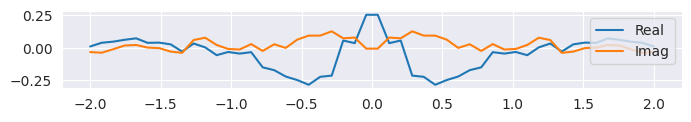

In [21]:
evolved_state = evolve_state(omega_list, time_list)
plt.figure(figsize=(8,1))
plt.plot(valid_x, np.real(evolved_state), label="Real")
plt.plot(valid_x, np.imag(evolved_state), label="Imag")
plt.legend(loc="best")